In [196]:
dfpd_train_sel.columns

Index(['REG_NC_is_same_state', 'REG_order_approved_date', 'REG_NC_distance',
       'REG_NC_days_for_shipping_limit', 'REG_NC_seller_complaint_ratio',
       'REG_days_to_deliver', 'days_to_estimate'],
      dtype='object')

In [327]:
import pandas as pd
from sklearn import preprocessing

dfpd_train_sel = pd.read_pickle("dfpd_train_sel.pkl")
dfpd_test_sel  = pd.read_pickle("dfpd_test_sel.pkl")


selected_features = ['REG_NC_is_same_state',
 'REG_order_approved_date',
 'REG_NC_distance',
 'REG_NC_days_for_shipping_limit',
 'REG_NC_seller_complaint_ratio']


scaler = preprocessing.StandardScaler().fit(dfpd_train_sel[selected_features])
dfpd_train_sel[selected_features] = scaler.transform(dfpd_train_sel[selected_features])
dfpd_test_sel[selected_features]  = scaler.transform(dfpd_test_sel[selected_features])

equalizer, deequalizer = equalize_cont(dfpd_train_sel, 'REG_days_to_deliver')

equalizer = lambda x: x
deequalizer = lambda x: x


dfpd_train_sel['REG_days_to_deliver_eq'] = dfpd_train_sel['REG_days_to_deliver'].apply(equalizer)
dfpd_test_sel ['REG_days_to_deliver_eq'] = dfpd_test_sel ['REG_days_to_deliver'].apply(equalizer)


target = 'days_to_deliver_eq'
#target = 'days_to_deliver'

REG_PREFIX = "REG_"

GLOBAL_SEED = 123

In [328]:
dfpd_test_sel

,REG_NC_is_same_state,REG_order_approved_date,REG_NC_distance,REG_NC_days_for_shipping_limit,REG_NC_seller_complaint_ratio,REG_days_to_deliver,days_to_estimate,REG_days_to_deliver_eq
0,1.078152,1.431853,-0.978359,2.825353,0.483106,4.0,17,4.0
1,-0.927513,-1.956272,1.304026,4.226370,1.065099,12.0,39,12.0
2,1.078152,0.854033,-0.997407,-1.377699,-0.819448,2.0,8,2.0
3,1.078152,0.735843,-1.030307,0.023318,0.888700,4.0,14,4.0
4,-0.927513,0.584822,1.304521,0.023318,-0.819448,13.0,27,13.0
...,...,...,...,...,...,...,...,...
15622,-0.927513,0.138325,-0.158466,-0.326936,0.847504,8.0,27,8.0
15623,1.078152,0.499462,0.062213,0.023318,-0.819448,8.0,20,8.0
15624,1.078152,1.313663,-0.644005,0.373572,-0.819448,5.0,16,5.0
15625,-0.927513,0.808070,0.246872,-0.677191,0.306489,8.0,22,8.0


In [329]:
dfpd_train_sel.count()

REG_NC_is_same_state              36921
REG_order_approved_date           36921
REG_NC_distance                   36921
REG_NC_days_for_shipping_limit    36921
REG_NC_seller_complaint_ratio     36921
REG_days_to_deliver               36921
days_to_estimate                  36921
REG_days_to_deliver_eq            36921
dtype: int64

In [341]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import time

#
#      ['lbfgs'] # solver
#    , ['tanh'] # activation
#    , [8,10,12,15,17] # alpha
#    , [1,2,3] # hidden_layer_sizes
#    , [1] # number of layers
#]

perceptrons_per_layer = 500
n_layers = 2
hidden_layer_sizes = tuple([perceptrons_per_layer]*n_layers)

combinations = [
    dict(activation='identity', alpha=1e-9 , hidden_layer_sizes=tuple([1]*1   ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([1]*1   ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([1]*2   ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10]*2  ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10]*4  ), max_iter=1e8 ) ### GOOD!
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([5]*4  ), max_iter=1e8 )
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([20]*4  ), max_iter=1e8 )
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10]*3  ), max_iter=1e8 )
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10]*4  ), max_iter=1e9 ) ### 7.274606594426504
  #  , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,20,20,10]), max_iter=1e9 ) # 7.273639367246028
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,5,5,10]), max_iter=1e9 )   
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 7.26411926953875
  # , dict(activation='relu', alpha=1e-8 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 )
  # , dict(activation='relu', alpha=1e-7 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 )
  # , dict(activation='relu', alpha=1e-6 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 7.266601041091493
  # , dict(activation='relu', alpha=1e-5 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 
  # , dict(activation='relu', alpha=1e-4 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 7.248251544924773
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([1]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([2]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([3]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([4]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([5]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([6]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([7]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 10]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 8, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 9, 11]      ), max_iter=1e9 ) # GOOD! 7.241438907179123
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 8, 8, 8 , 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 8, 8, 9 , 11]      ), max_iter=1e9 ) #
    
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 10, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 8 , 11, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 9,  8, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 10, 8,  11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 11, 8,  11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 9 , 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 10, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 11, 11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 12]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([8, 13]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([9]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([10]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([11]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([10,10]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([20,20]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([30,30]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([40,40]      ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([50,50]      ), max_iter=1e9 ) #
   , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([100]        ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([200]        ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([300]        ), max_iter=1e9 ) #
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([10,40,40,10]), max_iter=1e6 ) # 
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([10, 5, 5,10]), max_iter=1e6 ) # 
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([20,20,20,20]), max_iter=1e6 ) # 
  # , dict(activation='relu', alpha=1e-3 , hidden_layer_sizes=tuple([30,30,30,30]), max_iter=1e6 ) # 
  # , dict(activation='relu', alpha=1e-2 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 
  # , dict(activation='relu', alpha=1e-1 , hidden_layer_sizes=tuple([10,30,30,10]), max_iter=1e9 ) # 
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,40,40,10]), max_iter=1e9 ) 
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,50,50,10]), max_iter=1e9 ) 
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,30,20,10]), max_iter=1e9 ) 
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,20,30,10]), max_iter=1e9 ) 
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,40,40,10]), max_iter=1e9 ) 
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([20,50,50,20]), max_iter=1e9 ) 
  #  , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,11,11,10]), max_iter=1e9 )
  #  , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([13,12,11,10]), max_iter=1e9 )
  #  , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10,11,12,13]), max_iter=1e9 )
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([9]*4  ), max_iter=1e9 )
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([11]*4  ), max_iter=1e9 ) #7.276977938402567
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10]*4  ), max_iter=1e10 )#7.283822537656211
  # , dict(activation='relu', alpha=1e-10 , hidden_layer_sizes=tuple([10]*4  ), max_iter=1e9 ) #7.274606594426504
  # , dict(activation='relu', alpha=1e-10 , hidden_layer_sizes=tuple([10]*4  ), max_iter=1e10 )
  # , dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([200]*1  ), max_iter=1e9 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([10]*5  ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([50]*1  ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([50]*2  ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([100]*4 ), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([1000]*1), max_iter=1e8 )
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([1000]*1), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([1000]*2), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([200]*2 ), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-9 , hidden_layer_sizes=tuple([500]*2 ), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-11, hidden_layer_sizes=tuple([1000]*1), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-11, hidden_layer_sizes=tuple([1000]*2), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-11, hidden_layer_sizes=tuple([200]*2 ), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-11, hidden_layer_sizes=tuple([500]*2 ), max_iter=1e10)
  #, dict(activation='tanh', alpha=1e-9 , hidden_layer_sizes=tuple([200]*2 ), max_iter=1e10)
  #, dict(activation='tanh', alpha=1e-9 , hidden_layer_sizes=tuple([500]*2 ), max_iter=1e10)
  #, dict(activation='relu', alpha=1e-11, hidden_layer_sizes=tuple([1000]*2), max_iter=1e10)
]

results = []
lower_rmse_test = None
lower_rmse_model = None


def find_rmse(x_pred, x_target):
    return ((x_pred - x_target) ** 2).mean() ** .5

import json
with open("results.txt", 'w') as f_out:
  for counter, c in enumerate(combinations):
    #pd_mlp_config = MLPRegressor(
    #  random_state=GLOBAL_SEED
    #  #, max_iter=1e8
    #  , solver = 'lbfgs'
    #  #, activation = 'relu'
    #  #, alpha = 1e-9
    #  #, hidden_layer_sizes = hidden_layer_sizes
    #  , **c
    #)
    pd_mlp_config = MLPRegressor(random_state=GLOBAL_SEED, solver = 'lbfgs', **c)


    print(f"Fitting {counter+1}... ", end="")
    time_begin = time.time()
    pd_mlp_model = pd_mlp_config.fit(dfpd_train_sel[selected_features], dfpd_train_sel[f'{REG_PREFIX}{target}'])
    delta = time.time()-time_begin
    print(f"OK ({delta:.2} seconds)")

    dfpd_mlp_pred_train = pd_mlp_model.predict(dfpd_train_sel[selected_features])
    dfpd_mlp_pred_test  = pd_mlp_model.predict(dfpd_test_sel [selected_features])

    dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'] = dfpd_mlp_pred_train
    dfpd_test_sel [f'{REG_PREFIX}PRED_{target}'] = dfpd_mlp_pred_test

    
    
    
    rmse_train = find_rmse(
          dfpd_train_sel[f'{REG_PREFIX}{target}'     ].apply(deequalizer)
        , dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'].apply(deequalizer)
    )
    rmse_test  = find_rmse(
          dfpd_test_sel [f'{REG_PREFIX}{target}'     ].apply(deequalizer)
        , dfpd_test_sel [f'{REG_PREFIX}PRED_{target}'].apply(deequalizer)
    )

    score_train = pd_mlp_model.score(dfpd_train_sel[selected_features], dfpd_train_sel[f'{REG_PREFIX}{target}'])
    score_test  = pd_mlp_model.score(dfpd_test_sel [selected_features], dfpd_test_sel [f'{REG_PREFIX}{target}'])

    result_line = {
        'combination': c
      , 'rmse_train' : float(rmse_train )
      , 'rmse_test'  : float(rmse_test  )
      , 'score_train': float(score_train)
      , 'score_test' : float(score_test )
      , 'elapsed_time' : delta
    }
    f_out.write(
        json.dumps(results)
      )
    results.append(result_line)

    if lower_rmse_test is None or lower_rmse_test > rmse_test:
      lower_rmse_test = rmse_test
      lower_rmse_model = pd_mlp_model
      print("BEST MODEL!!")
    print(f"DONE ({round(delta,2)} seconds, rmse_train: {rmse_train}, rmse_test: {rmse_test})")
    print()
  
#print(results)



pd_mlp_model = lower_rmse_model
dfpd_mlp_pred_train = pd_mlp_model.predict(dfpd_train_sel[selected_features])
dfpd_mlp_pred_test  = pd_mlp_model.predict(dfpd_test_sel [selected_features])

dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'] = dfpd_mlp_pred_train
dfpd_test_sel [f'{REG_PREFIX}PRED_{target}'] = dfpd_mlp_pred_test


Fitting 1... OK (0.027 seconds)
BEST MODEL!!
DONE (0.03 seconds, rmse_train: 7.3543599261299315, rmse_test: 7.385796496160187)

Fitting 2... OK (6.5e+02 seconds)
BEST MODEL!!
DONE (645.11 seconds, rmse_train: 6.74880372186427, rmse_test: 6.9226262471414834)



In [267]:
import numpy as np
import matplotlib.pyplot as plt

In [332]:
dfpd_train_sel[[f'{REG_PREFIX}{target}', f'{REG_PREFIX}PRED_{target}']]

,REG_days_to_deliver_eq,REG_PRED_days_to_deliver_eq
0,7.0,7.997849
1,13.0,3.278256
2,8.0,6.168782
3,13.0,15.717112
4,5.0,10.065043
...,...,...
36916,10.0,10.796632
36917,9.0,11.101500
36918,13.0,8.389092
36919,6.0,5.425376


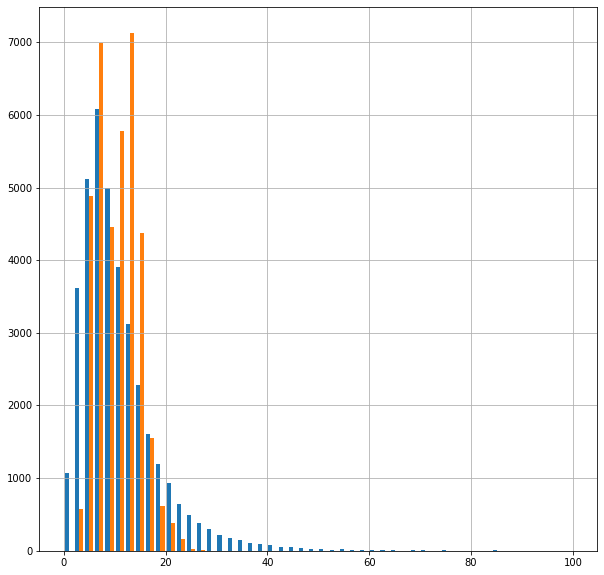

In [339]:
error = ""
try:
  f, ax = plt.subplots(1,1,figsize=(10,10))
  ax.hist(
      [
            dfpd_train_sel[f'{REG_PREFIX}{target}'     ].apply(deequalizer)
          , dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'].apply(deequalizer)
      ]
      , bins=50, range=(0,100))
  #ax.hist(dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'].apply(deequalizer), bins=50, color="red", width=1, range=(0,100))
  ax.grid(True)
  plt.show()
except Exception as e:
  error = str(e)

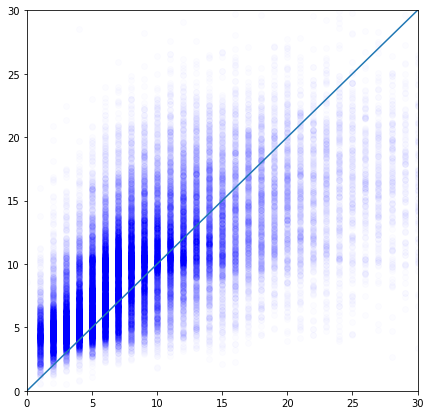

In [342]:
f, ax = plt.subplots(1,1,figsize=(7,7))

ax.scatter(
    dfpd_train_sel[f'{REG_PREFIX}{target}'].apply(deequalizer)
    , dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'].apply(deequalizer)
    , color=(0,0,1,.01)
)
ax.set_xlim(0,30)
ax.set_ylim(0,30)
ax.plot([0,30],[0,30])

plt.show()

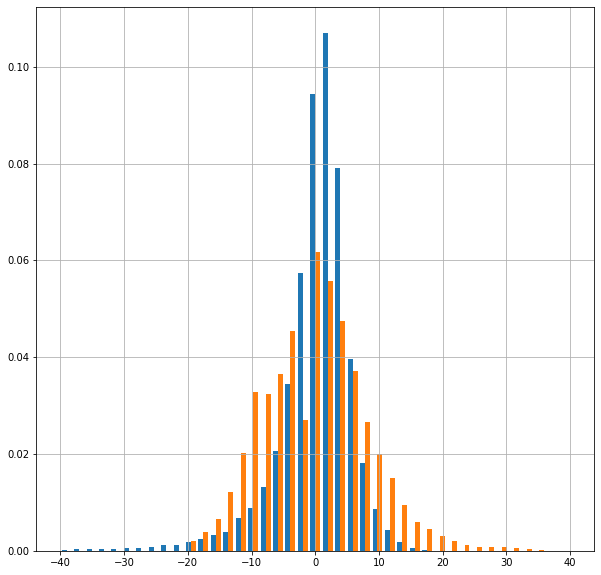

In [343]:
f, ax = plt.subplots(1,1,figsize=(10,10))
ax.hist(
    [
        dfpd_train_sel[f'{REG_PREFIX}PRED_{target}'].apply(deequalizer)-dfpd_train_sel[f'{REG_PREFIX}{target}'].apply(deequalizer)
        , dfpd_train_sel[f'days_to_estimate']-dfpd_train_sel[f'days_to_estimate'].mean()
    ]
    , bins=41, range=(-40,40)
    , density=True
    , histtype='bar'
)

#ax.hist(
#    dfpd_train_sel[f'days_to_estimate']-dfpd_train_sel[f'days_to_estimate'].mean()
#    , bins=81, range=(-40+.5,40+.5)
#    , width=.3
#)
ax.grid(True)
plt.show()

In [214]:
dfpd_train_sel

,REG_NC_is_same_state,REG_order_approved_date,REG_NC_distance,REG_NC_days_for_shipping_limit,REG_NC_seller_complaint_ratio,REG_days_to_deliver,days_to_estimate,REG_PRED_days_to_deliver
0,-0.927513,1.471250,0.263876,0.023318,-0.819448,7.0,27,7.691383
1,1.078152,1.412155,-0.943838,-1.377699,-0.819448,13.0,6,3.170900
2,1.078152,-1.050146,-0.889019,0.023318,1.163545,8.0,13,6.269173
3,-0.927513,-0.235945,0.648358,0.023318,-0.819448,13.0,21,13.287056
4,1.078152,0.059531,-0.206061,-0.326936,-0.819448,5.0,23,10.647577
...,...,...,...,...,...,...,...,...
36916,-0.927513,1.353059,2.100620,-0.326936,-0.819448,10.0,26,10.938847
36917,1.078152,0.289346,-0.210534,-0.326936,-0.819448,9.0,20,11.848996
36918,1.078152,0.748975,-0.360777,0.023318,1.254592,13.0,25,9.031440
36919,1.078152,0.781806,-0.827111,0.023318,-0.819448,6.0,13,5.447602


In [245]:

dfpd_count = (
        dfpd_train_sel['REG_days_to_deliver']
        .value_counts()
        .to_frame()
        .rename(columns={'REG_days_to_deliver': 'count'})
    ).sort_index()
dfpd_count['cumsum'] = dfpd_count['count'].cumsum()

min_cumsum = dfpd_count['cumsum'].min()
max_cumsum = dfpd_count['cumsum'].max()

dfpd_count['cumsum_norm'] = (dfpd_count['cumsum']-min_cumsum)/(max_cumsum-min_cumsum)


#dfpd_count['cumsum_norm'] = minmax_scaller(dfpd_count['cumsum']) #dfpd_count['cumsum']-
dfpd_count

,count,cumsum,cumsum_norm
0.0,1,1,0.000000
1.0,1067,1068,0.028900
2.0,1665,2733,0.073998
3.0,1954,4687,0.126923
4.0,2340,7027,0.190303
...,...,...,...
135.0,1,36917,0.999892
136.0,1,36918,0.999919
144.0,1,36919,0.999946
173.0,1,36920,0.999973


In [253]:
def equalize_cont(dfpd, target):
    dfpd_count = (
            dfpd_train_sel[target]
            .value_counts()
            .to_frame()
            .rename(columns={target: 'count'})
        ).sort_index()
    dfpd_count['cumsum'] = dfpd_count['count'].cumsum()

    min_cumsum = dfpd_count['cumsum'].min()
    max_cumsum = dfpd_count['cumsum'].max()

    dfpd_count['cumsum_norm'] = (dfpd_count['cumsum']-min_cumsum)/(max_cumsum-min_cumsum)
    equalizer   = lambda x: np.interp(x, dfpd_count.index         , dfpd_count['cumsum_norm'])
    deequalizer = lambda x: np.interp(x, dfpd_count['cumsum_norm'], dfpd_count.index         )
    
    return equalizer, deequalizer

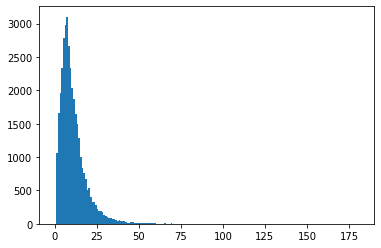

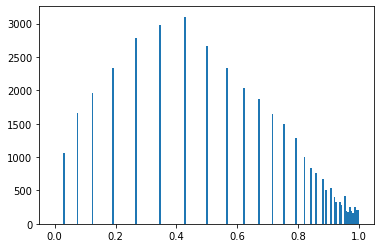

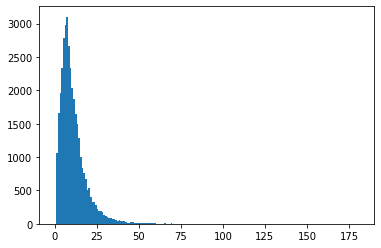

In [254]:
equalizer, deequalizer = equalize_cont(dfpd_train_sel, 'REG_days_to_deliver')
dfpd_eq = dfpd_train_sel.copy()
dfpd_eq['class']                    = dfpd_eq['REG_days_to_deliver'].apply(equalizer  )
dfpd_eq['REG_days_to_deliver_test'] = dfpd_eq['class'              ].apply(deequalizer)

dfpd_eq[[
    'REG_days_to_deliver'
    , 'class'
]]

dfpd_eq['class']


plt.hist(dfpd_eq['REG_days_to_deliver'], bins=int(dfpd_eq['REG_days_to_deliver'].max()))
plt.figure()
plt.hist(dfpd_eq['class'], bins=int(dfpd_eq['REG_days_to_deliver'].max()))
plt.figure()
plt.hist(dfpd_eq['REG_days_to_deliver_test'], bins=int(dfpd_eq['REG_days_to_deliver'].max()))
plt.show()


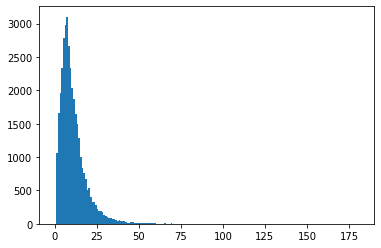

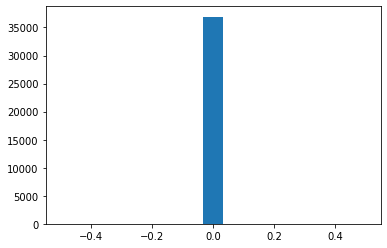

In [230]:

    
    
    
    



def equalize(dfpd, target, new_target, n_classes=10):
    dfpd_count = (
        dfpd[target]
        .value_counts()
        .to_frame()
        .rename(columns={'REG_days_to_deliver': 'count'})
    )
    dfpd_count = dfpd_count.sort_index()
    dfpd_count['cumsum'] = dfpd_count['count'].cumsum()

    min_cumsum = dfpd_count['cumsum'].min()
    max_cumsum = dfpd_count['cumsum'].max()
    bin_size = (max_cumsum-min_cumsum)/(n_classes-1)

    dfpd_count[new_target] = np.round((dfpd_target_count['cumsum']-min_cumsum)/bin_size)

    target2new = lambda target: np.round((target-min_cumsum)/bin_size) #{t: nt for t, nt in zip(dfpd_count.index, dfpd_count[new_target])}
    #new2target = {nt: t for t, nt in zip(dfpd_count.index, dfpd_count[new_target])}
    
    # apply to dataframe
    dfpd[new_target] = dfpd[target].apply(target2new)
    
    return dfpd, target2new#, new2target

n_classes = 15

dfpd_eq, target2new = equalize(dfpd_train_sel, 'REG_days_to_deliver', 'class', n_classes=n_classes)
    
plt.hist(dfpd_eq['REG_days_to_deliver'], bins=int(dfpd_eq['REG_days_to_deliver'].max()))
plt.figure()
plt.hist(dfpd_eq['class'], bins=n_classes)
plt.show()

# #dfpd_target_count = (
# #    dfpd_train_sel['REG_days_to_deliver']
# #    .value_counts()
# #    .to_frame()
# #    .rename(columns={'REG_days_to_deliver': 'count'})
# #)
# #
# #dfpd_target_count = dfpd_target_count.sort_index()
# #dfpd_target_count['cumsum'] = dfpd_target_count['count'].cumsum()
# #
# #min_cumsum = dfpd_target_count['cumsum'].min()
# #max_cumsum = dfpd_target_count['cumsum'].max()
# #N = dfpd_target_count.index.max()
# #bin_size = (max_cumsum-min_cumsum)/(N-1)
# #
# #dfpd_target_count['class'] = np.round((dfpd_target_count['cumsum']-min_cumsum)/bin_size)
# 
# 
# 
# 
# 
# dfpd_target_count
# 
# #plt.bar(dfpd_target_count.index, dfpd_target_count['count'])
# 
# dfpd_classes = dfpd_target_count.groupby('class').agg({'count': 'sum'})
# dfpd_classes['class_cumsum'] = dfpd_classes['count'].cumsum()
# 
# dfpd_classes
# 
# plt.plot(dfpd_classes.index, dfpd_classes['class_cumsum'])
# plt.plot(dfpd_target_count.index, dfpd_target_count['cumsum'])
# 
# plt.figure()
# plt.bar(dfpd_classes.index, dfpd_classes['count'])


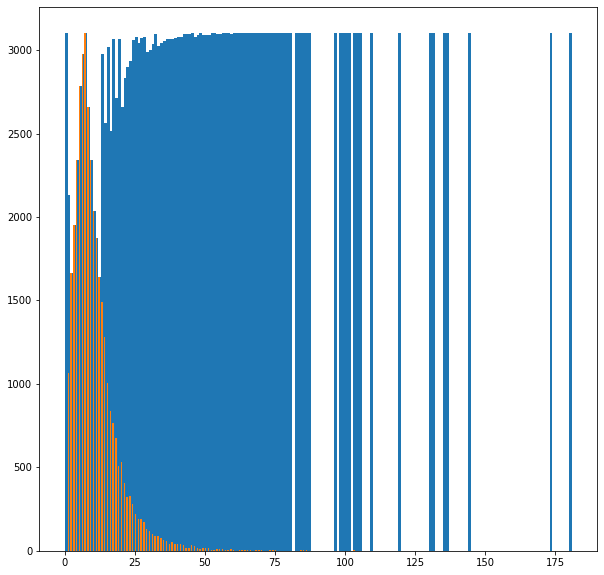

In [109]:
dfpd_target_count = (
    dfpd_train_sel['REG_days_to_deliver']
    .value_counts()
    .to_frame()
    .rename(columns={'REG_days_to_deliver': 'count'})
)

dfpd_train_sel_aux = (
    dfpd_train_sel
    .set_index('REG_days_to_deliver')
    .join(dfpd_target_count)
)
dfpd_train_sel_aux['REG_days_to_deliver'] = dfpd_train_sel_aux.index
dfpd_train_sel_aux = dfpd_train_sel_aux.reset_index()

max_count = dfpd_train_sel_aux["count"].max()

dfpd_train_sel_aux['aux'] = dfpd_train_sel_aux.apply(lambda r: [1]*int(max_count/r['count']), axis=1) #.apply(np.array)

dfpd_train_sel_aux = dfpd_train_sel_aux.explode('aux')

dfpd_train_sel_aux

f, ax = plt.subplots(1,1,figsize=(10,10))
ax.hist(dfpd_train_sel_aux[f'{REG_PREFIX}{target}'], bins=int(dfpd_train_sel_aux[f'{REG_PREFIX}{target}'].max()))
ax.hist(dfpd_train_sel    [f'{REG_PREFIX}{target}'], bins=int(dfpd_train_sel    [f'{REG_PREFIX}{target}'].max()), width=.5)
plt.show()

In [82]:
dfpd_train_sel.count()

REG_NC_is_same_state              36921
REG_order_approved_date           36921
REG_NC_distance                   36921
REG_NC_days_for_shipping_limit    36921
REG_NC_seller_complaint_ratio     36921
REG_days_to_deliver               36921
days_to_estimate                  36921
REG_PRED_days_to_deliver          36921
dtype: int64

In [79]:
dfpd_target_count = (
    dfpd_train_sel['REG_days_to_deliver']
    .value_counts()
    .to_frame()
    .rename(columns={'REG_days_to_deliver': 'count'})
)
dfpd_target_count[target] = dfpd_target_count.index

dfpd_target_count


,count,days_to_deliver
7.0,3102,7.0
6.0,2974,6.0
5.0,2782,5.0
8.0,2659,8.0
9.0,2340,9.0
...,...,...
67.0,1,67.0
87.0,1,87.0
99.0,1,99.0
109.0,1,109.0


In [67]:
dfpd_train_sel

,REG_NC_is_same_state,REG_order_approved_date,REG_NC_distance,REG_NC_days_for_shipping_limit,REG_NC_seller_complaint_ratio,REG_days_to_deliver,days_to_estimate,REG_PRED_days_to_deliver
0,0.0,1.534378e+09,536.959529,6.0,0.000000,7.0,27,10.510184
1,1.0,1.533600e+09,39.096552,2.0,0.000000,13.0,6,10.510184
2,1.0,1.501200e+09,61.694980,6.0,0.044776,8.0,13,10.510184
3,0.0,1.511914e+09,695.456694,6.0,0.000000,13.0,21,10.510184
4,1.0,1.515802e+09,343.234526,5.0,0.000000,5.0,23,10.510184
...,...,...,...,...,...,...,...,...
36916,0.0,1.532822e+09,1294.131241,5.0,0.000000,10.0,26,10.510184
36917,1.0,1.518826e+09,341.390532,5.0,0.000000,9.0,20,10.510184
36918,1.0,1.524874e+09,279.455049,6.0,0.046832,13.0,25,10.510184
36919,1.0,1.525306e+09,87.215576,6.0,0.000000,6.0,13,10.510184
